In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [15]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### load MNIST data

In [16]:
from scipy.io import loadmat
train_mnist = loadmat('mnist_train.mat')

In [17]:
data = train_mnist['train_X']
data.shape

(60000, 784)

In [18]:
labels = train_mnist['train_labels']
labels.shape

(60000, 1)

downsample data to 10000

In [19]:
idx = np.random.randint(60000, size=10000)
data = data[idx, :]
labels = labels[idx]
labels = labels[:,0].tolist()

### compute symmetric joint probabilities in the original high-dimensional space

In [20]:
def Hbeta(D, beta):
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(np.multiply(D, P)) / sumP
    P = P / sumP
    return H, P

def x2p(X, u=15, tol=1e-4, print_iter=2500, max_tries=50, verbose=0):
    # Initialize some variables
    n = X.shape[0]                     # number of instances
    P = np.zeros((n, n))               # empty probability matrix
    beta = np.ones(n)                  # empty precision vector
    logU = np.log(u)                   # log of perplexity (= entropy)
    
    # Compute pairwise distances
    if verbose > 0: print('Computing pairwise distances...')
    sum_X = np.sum(np.square(X), axis=1)
    # note: translating sum_X' from matlab to numpy means using reshape to add a dimension
    D = sum_X + sum_X[:,None] + -2 * X.dot(X.T)

    # Run over all datapoints
    if verbose > 0: print('Computing P-values...')
    for i in range(n):
        
        if verbose > 1 and print_iter and i % print_iter == 0:
            print('Computed P-values {} of {} datapoints...'.format(i, n))
        
        # Set minimum and maximum values for precision
        betamin = float('-inf')
        betamax = float('+inf')
        
        # Compute the Gaussian kernel and entropy for the current precision
        indices = np.concatenate((np.arange(0, i), np.arange(i + 1, n)))
        Di = D[i, indices]
        H, thisP = Hbeta(Di, beta[i])
        
        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while abs(Hdiff) > tol and tries < max_tries:
            
            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i]
                if np.isinf(betamax):
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i]
                if np.isinf(betamin):
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + betamin) / 2
            
            # Recompute the values
            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1
        
        # Set the final row of P
        P[i, indices] = thisP
        
    if verbose > 0: 
        print('Mean value of sigma: {}'.format(np.mean(np.sqrt(1 / beta))))
        print('Minimum value of sigma: {}'.format(np.min(np.sqrt(1 / beta))))
        print('Maximum value of sigma: {}'.format(np.max(np.sqrt(1 / beta))))
    
    return P, beta

def compute_joint_probabilities(samples, batch_size=5000, d=2, perplexity=30, tol=1e-5, verbose=0):
    v = d - 1
    
    # Initialize some variables
    n = samples.shape[0]
    batch_size = min(batch_size, n)
    
    # Precompute joint probabilities for all batches
    if verbose > 0: print('Precomputing P-values...')
    batch_count = int(n / batch_size)
    P = np.zeros((batch_count, batch_size, batch_size))
    for i, start in enumerate(range(0, n - batch_size + 1, batch_size)):   
        curX = samples[start:start+batch_size]                   # select batch
        P[i], beta = x2p(curX, perplexity, tol, verbose=verbose) # compute affinities using fixed perplexity
        P[i][np.isnan(P[i])] = 0                                 # make sure we don't have NaN's
        P[i] = (P[i] + P[i].T) # / 2                             # make symmetric
        P[i] = P[i] / P[i].sum()                                 # obtain estimation of joint probabilities
        P[i] = np.maximum(P[i], np.finfo(P[i].dtype).eps)

    return P

In [23]:
batch_size = 2500
P = compute_joint_probabilities(data, batch_size=batch_size, verbose=0 )

### construct the neural network

In [9]:
D_in, fc1, fc2, fc3, D_out = 784, 4000, 4000, 3000, 2

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, fc1), torch.nn.BatchNorm1d(fc1), torch.nn.ReLU(),
    torch.nn.Linear(fc1, fc2), torch.nn.BatchNorm1d(fc2), torch.nn.ReLU(),
    torch.nn.Linear(fc2, fc3), torch.nn.BatchNorm1d(fc3), torch.nn.ReLU(),
    torch.nn.Linear(fc3, D_out)
)

### define t-SNE loss function

In [10]:
def tsne_loss(P, activations):
    n = activations.size(0)
    alpha = 1
    eps = 1e-8
    sum_act = torch.sum(torch.pow(activations, 2), 1)
    Q = sum_act + sum_act.view([-1, 1]) - 2 * torch.matmul(activations, torch.transpose(activations, 0, 1))
    Q = Q / alpha
    Q = torch.pow(1 + Q, -(alpha + 1) / 2)
    Q = Q * autograd.Variable(1 - torch.eye(n), requires_grad=False)
    Q = Q / torch.sum(Q)
#     Q = torch.clamp(Q, min=eps)
    C = torch.log((P + eps) / (Q + eps))
    C = torch.sum(P * C)
    return C

### prepare mini-batch data

In [27]:
n = data.shape[0]
batch_size = min(batch_size, n)
batch_count = int(n / batch_size)

### learning rate schedule

In [29]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 150 epochs"""
    lr = 0.1 * (0.2 ** (epoch // 150))
    lr = max(lr, 1e-2)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

### train the network

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
for epoch in range(450):      
    adjust_learning_rate(optimizer, epoch)
    for i, start in enumerate(range(0, n - batch_size + 1, batch_size)):   
        curX = data[start:start+batch_size]  
        curP = P[start:start+batch_size, start:start+batch_size]
        x_var = autograd.Variable(torch.Tensor(curX), requires_grad=False)
        P_var = autograd.Variable(torch.Tensor(curP), requires_grad=False)
        y_pred = model(x_var)
        loss = tsne_loss(P_var, y_pred)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print('epoch {}: loss {}'.format(epoch, loss.data[0]))

epoch 0: loss 3.6217665672302246
epoch 1: loss 3.2801458835601807
epoch 2: loss 3.271462917327881
epoch 3: loss 3.171415090560913
epoch 4: loss 3.082972288131714
epoch 5: loss 2.772472858428955
epoch 6: loss 2.6789910793304443
epoch 7: loss 2.4929027557373047
epoch 8: loss 2.3867733478546143
epoch 9: loss 2.278806686401367
epoch 10: loss 2.1929209232330322
epoch 11: loss 2.0826539993286133
epoch 12: loss 2.0068373680114746
epoch 13: loss 1.9465253353118896
epoch 14: loss 1.8760584592819214
epoch 15: loss 1.8204597234725952
epoch 16: loss 1.780900001525879
epoch 17: loss 1.7536433935165405
epoch 18: loss 1.7504931688308716
epoch 19: loss 1.6962432861328125
epoch 20: loss 1.7131922245025635
epoch 21: loss 1.6701971292495728
epoch 22: loss 1.6588979959487915
epoch 23: loss 1.6229171752929688
epoch 24: loss 1.5994102954864502
epoch 25: loss 1.5838603973388672
epoch 26: loss 1.565798282623291
epoch 27: loss 1.5679000616073608
epoch 28: loss 1.5437296628952026
epoch 29: loss 1.59171032905578

### see how DNN fit the training data

In [31]:
data_var = autograd.Variable(torch.Tensor(data))
data_pro_va = model(data_var)

In [32]:
data_embed = data_pro_va.data.numpy()

In [37]:
data_embed.shape

(10000, 2)

In [33]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
print(__version__) # requires version >= 1.9.0
from plotly.graph_objs import *
init_notebook_mode(connected=True)

2.0.8


In [40]:
import colorlover as cl

In [57]:
colors = cl.scales['11']['qual']['Paired']

In [58]:
scatter_color = [colors[x] for x in labels]

In [59]:
mot = Scatter(
    x=data_embed[:,0],
    y=data_embed[:,1],
    mode='markers',
    text=labels,
    marker=dict(
        size = 3,
        color = scatter_color
    )
) 

layout = Layout(
        width=750,
        height=750,
        margin=Margin(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        ),
        xaxis=dict(
            zeroline=False
        ),
        yaxis=dict(
            zeroline=False
        ),
        legend=dict(orientation="h"),
        showlegend=True,
        hovermode ='closest',
    )

iplot({
    'data': [mot],
    'layout': layout
    },
    show_link=False)

### predict the data and visualization

In [61]:
tst_data = train_mnist['train_X']
tst_idx = np.random.randint(60000, size=10000)
tst_data = tst_data[tst_idx, :]

tst_labels = train_mnist['train_labels']
tst_labels = tst_labels[tst_idx, 0].tolist()

tst_x_var = autograd.Variable(torch.Tensor(tst_data))

In [62]:
tst_y_pred = model(tst_x_var)

In [63]:
tst_data_embed = tst_y_pred.data.numpy()

In [64]:
scatter_color = [colors[x] for x in tst_labels]

In [65]:
tst_points = Scatter(
    x=tst_data_embed[:,0],
    y=tst_data_embed[:,1],
    mode='markers',
    marker=dict(
        size = 3,
        color = scatter_color
    )
) 

iplot({
    'data': [tst_points],
    'layout': layout
    },
    show_link=False)

### visulization the network

In [48]:
x_tnsr = torch.Tensor(data)
type(x_tnsr)

torch.FloatTensor

In [50]:
tst_y_pred = model(tst_x_var)

In [51]:
tst_data_embed = tst_y_pred.data.numpy()

In [52]:
scatter_color = [colors[x] for x in tst_labels]

### visulization the network

In [212]:
x = autograd.Variable(x_tnsr)
type(x)

torch.autograd.variable.Variable

In [205]:
y_pred = model(x)

In [159]:
from graphviz import Digraph
import torch
from torch.autograd import Variable


def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph

    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function

    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    pass
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

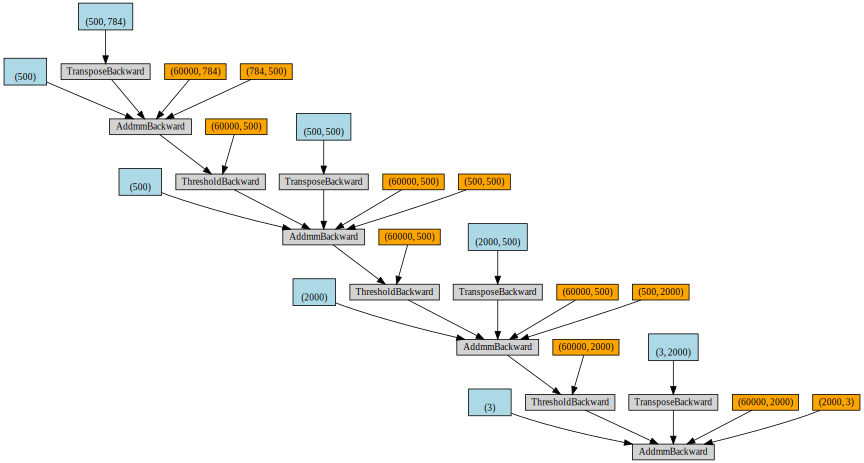

In [160]:
make_dot(y_pred)